In [4]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from copia import chao1

In [5]:
plt.style.use('science')

# Functions

In [31]:
def chao_wor(x, q, conf=0.95):
    x = x[x > 0]
    n = x.sum() # sample size
    t = len(x)  # number of unique items
    # Convert the int64 to longs to ensure the numbers
    # don't get too big in the variance calculation
    f1 = (x == 1).sum().item() # number of singletons
    f2 = (x == 2).sum().item() # number of doubletons
    w = n / (n - 1)
    r = q / (1 - q)
    f0 = (f1 ** 2) / (2 * w * f2 + r * f1)

    # compute sd
    t1 = ((2 * w * f2 * (f0**2) + (f1**2) * f0) ** 2) / (f1 ** 5)
    t2 = (4 * (w**2) * f2) * ((f0 / f1)**4)
    var = f0 + t1 + t2
        
    z = abs(stats.norm.ppf((1 - conf) / 2))
    K = np.exp(z * np.sqrt(np.log(1 + var / f0 ** 2)))
    lci, uci = t + f0 / K, t + f0 * K
    return {
        "q": q,
        "f1": f1,
        "f2": f2,
        "f0": f0,
        "V_obs": t,
        "V_est": int(t + f0), ##turned this into integer
        "var": var,
        "sd": np.sqrt(var),
        "lci": lci,
        "uci": uci,
        "Chao1": chao1(x)
    }

# Loading Data

In [7]:
df = pd.read_csv('../data/raw/vocapture.csv')
df.head()

,vocop_id,disambiguated_person,person_cluster_id,date_begin_contract,outward_voyage_id
0,104944,1.0,415682.0,1700-05-05,92895
1,104945,1.0,406243.0,1700-05-05,92895
2,104946,1.0,1.0,1700-05-05,92895
3,104947,1.0,77235.0,1700-05-05,92895
4,104948,1.0,65732.0,1700-05-05,92895


__vocop_id__: the unique id for each contract \
__disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). \
__person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person \
__date_begin_contract__: start date of contract \
__outward_voyage_id__: unique id of outward voyage. 

In [8]:
print(f'total number of contracts: {df.shape[0]}')

total number of contracts: 774200


In [13]:
nans = df['date_begin_contract'].isnull().sum()
print(f'number of nans in date field: {nans}')
df = df.dropna(subset=['date_begin_contract'])

number of nans in date field: 257


In [14]:
#only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1]['person_cluster_id'].astype(int).values
print(f'number of disambiguated records: {len(records)}')

number of disambiguated records: 546973


In [15]:
# construct year variable as Pandas is notoriously bad at working with dates before 1643

df['year'] = df['date_begin_contract'].str.split('-', expand=True)[0].astype(int)
df = df.sort_values(by='year')

## plot time series




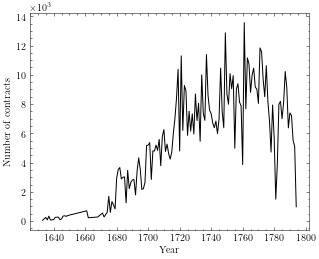

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))

df.groupby(pd.Grouper(key='year'))['date_begin_contract'].count().plot(ax=ax, color="k")
ax.set(xlabel='Year', ylabel='Number of contracts')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.savefig('../figures/total_contracts.png', dpi=300)

In [26]:
mean_sailors = df.groupby(['outward_voyage_id'])['person_cluster_id'].count().mean()
print(f'mean sailors on a ship: {mean_sailors}')
n_records = 4_352

mean sailors on a ship: 173.14751503640392


Given that there were 4,352 voyages, we can make estimate the observed number of sailors (4,352 * 181): 787,712. 

In [27]:
N_est = int(mean_sailors * n_records)
print(N_est)

753537


In [28]:
counts = np.array(list(collections.Counter(records).values()))
N_obs, V_obs = counts.sum(), counts.shape[0]

#N, V = len(records), len(np.unique(records))
print(f"The archive consists of N={N_obs} records and V_obs={V_obs} unique sailors.")

The archive consists of N=546973 records and V_obs=460274 unique sailors.


In [29]:
q = N_obs / N_est
print(q)

0.725874111025736


In [33]:
estimates = chao_wor(counts, q)

In [34]:
estimates

{'q': 0.725874111025736,
 'f1': 401179,
 'f2': 42889,
 'f0': 140185.41571152065,
 'V_obs': 460274,
 'V_est': 600459,
 'var': 199321.97618833484,
 'sd': 446.4548982689459,
 'lci': 599587.1077018755,
 'uci': 601337.1856714176,
 'Chao1': 2336562.7429766366}

In [35]:
estimates['V_est'] /estimates['V_obs']

1.3045685830613938

Note that Chao1 gives an unrealistic lowerbound of more than 2 million, which by far exceeds the know upper limt of N_est. 

## per 25 years

In [16]:
date_ranges = []
x = 1633
y = 0
while y < 1795:
    y = x + 25
    if y > 1795:
        y = 1795
    date_ranges.append((x, y))
    x = y


date_ranges


[(1633, 1658),
 (1658, 1683),
 (1683, 1708),
 (1708, 1733),
 (1733, 1758),
 (1758, 1783),
 (1783, 1795)]

In [17]:
DAS_voyages = [468, 586, 620, 884, 848, 718, 383]

In [18]:
estimates = []
V_observations = []
for index, date in enumerate(date_ranges):
    print(date)
    df_slice = df[df['year'].between(date[0], date[1])]

    mean_sailors = int(df_slice.groupby(['outward_voyage_id'])['person_cluster_id'].count().mean())
    print(f'mean number of sailors:{mean_sailors}')
    V = DAS_voyages[index] * mean_sailors
    records = df_slice.loc[df_slice['disambiguated_person'] == 1]['person_cluster_id'].astype(int).values
    counts = np.array(list(collections.Counter(records).values()))
    N, V_obs = counts.sum(), counts.shape[0]
    V_observations.append(V_obs)
    q = len(records) / V
    estimate = chao_wor(counts, q)
    estimates.append(estimate)

(1633, 1658)
mean number of sailors:145
(1658, 1683)
mean number of sailors:74
(1683, 1708)
mean number of sailors:124
(1708, 1733)
mean number of sailors:157
(1733, 1758)
mean number of sailors:186
(1758, 1783)
mean number of sailors:219
(1783, 1795)
mean number of sailors:177


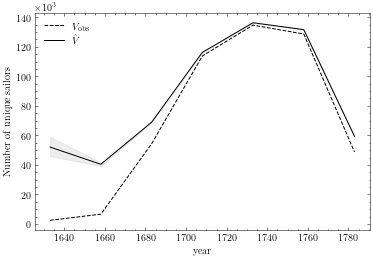

In [61]:
labels = [x[0] for x in date_ranges]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(labels, V_observations, label=r'$V_{\text{obs}}$', color="k", linestyle='dashed')
lci, uci, est = zip(*[(est["lci"], est["uci"], est["V_est"]) for est in estimates])
ax.plot(labels, est, color="k", label=r'$\hat{V}$')
ax.fill_between(labels, lci, uci, color="lightgrey", alpha=0.4)
ax.set(xlabel='year', ylabel='Number of unique sailors')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
ax.legend()
plt.savefig('../figures/25year_plot.png', dpi=300)